In [33]:
import sklearn
print(sklearn.__version__)

1.7.1


In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load your data (adjust path/filename as needed)
df_clean = pd.read_csv("../build/fight_ml_dataset.csv")

# 2. Inspect data
display(df.head())
df = df.drop(columns=["judge_margins"])
print(df.info())
print(list(df.columns))

# 3. Encode categorical variables if needed (example: winner column)
# Assume 'winner' is the target: 1 = Fighter A, 0 = Fighter B
# df['winner'] = df['winner'].map({'A': 1, 'B': 0})

,DATE,EVENT,BOUT,fighter_a_name,fighter_b_name,winner_label,WEIGHTCLASS,METHOD,decision_type,method_class,...,age_diff,reach_inches_diff,height_inches_diff,weight_lbs_diff,win_rate_diff,total_fights_diff,total_wins_diff,total_losses_diff,total_draws_diff,target
0,1994-03-11,UFC 2: No Way Out,Frank Hamaker vs. Thaddeus Luster,Frank Hamaker,Thaddeus Luster,A,Open Weight Bout,Submission,other,finish,...,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,-1.0,0.0,1
1,1994-03-11,UFC 2: No Way Out,Jason DeLucia vs. Scott Baker,Jason DeLucia,Scott Baker,A,Open Weight Bout,Submission,other,finish,...,0.0,0.0,-1.0,-20.0,0.333333,2.0,1.0,1.0,0.0,1
2,1994-03-11,UFC 2: No Way Out,Johnny Rhodes vs. David Levicki,Johnny Rhodes,David Levicki,A,Open Weight Bout,KO/TKO,other,finish,...,0.0,0.0,-5.0,-65.0,0.666667,2.0,2.0,0.0,0.0,1
3,1994-03-11,UFC 2: No Way Out,Johnny Rhodes vs. Fred Ettish,Johnny Rhodes,Fred Ettish,A,Open Weight Bout,Submission,other,finish,...,0.0,0.0,0.0,30.0,0.666667,2.0,2.0,0.0,0.0,1
4,1994-03-11,UFC 2: No Way Out,Orlando Wiet vs. Robert Lucarelli,Orlando Wiet,Robert Lucarelli,A,Open Weight Bout,KO/TKO,other,finish,...,0.0,0.0,-4.0,-75.0,0.500000,1.0,1.0,0.0,0.0,1


KeyError: "['judge_margins'] not found in axis"

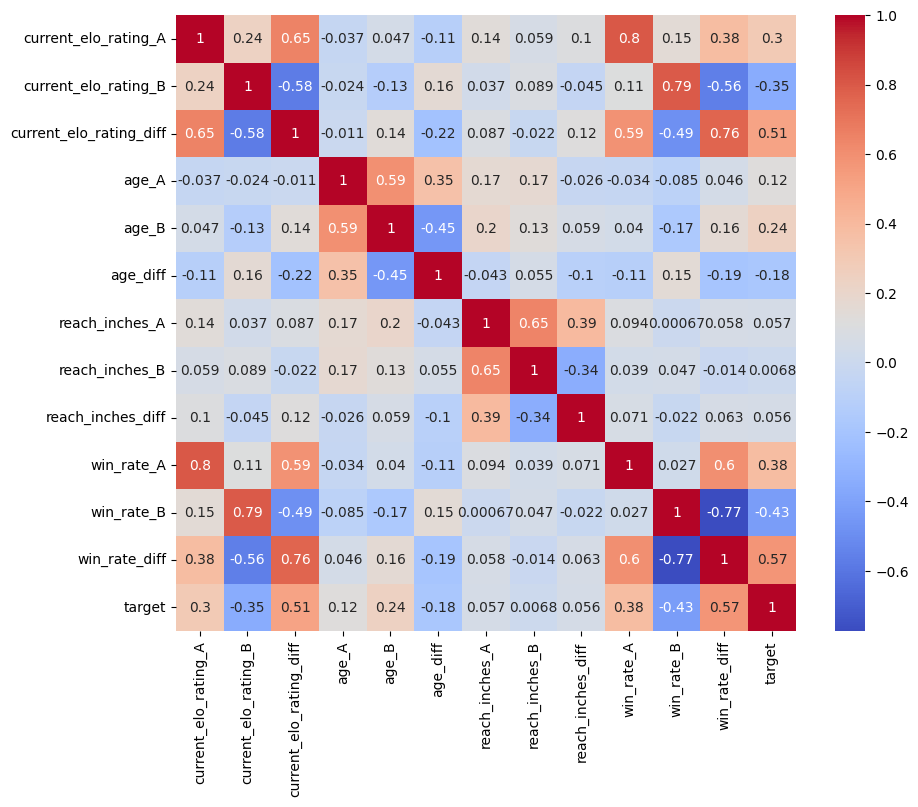

In [35]:
# 4. Check correlations
important_cols = [
    'current_elo_rating_A', 'current_elo_rating_B', 'current_elo_rating_diff', 'age_A', 'age_B', 'age_diff',
    'reach_inches_A', 'reach_inches_B', 'reach_inches_diff',
    'win_rate_A', 'win_rate_B', 'win_rate_diff',
    'target'
]
corr = df[important_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [36]:
# Fix multicollinearity by removing redundant features
print("Original features:", len(X.columns))
print("Checking for perfect correlations...")

# Remove redundant features that cause multicollinearity
redundant_features = [
    'total_fights_A',  # Redundant: total_wins_A + total_losses_A + total_draws_A
    'total_fights_B',  # Redundant: total_wins_B + total_losses_B + total_draws_B
    'total_fights_diff',  # Redundant: calculated from other totals
    'total_wins_diff',    # Can be derived from win_rate_diff
    'total_losses_diff',  # Can be derived from other features
    # Keep only the most informative features
]

# Remove redundant features
X_clean = X.drop(columns=[col for col in redundant_features if col in X.columns])

print(f"Removed {len(X.columns) - len(X_clean.columns)} redundant features")
print(f"Features after cleanup: {len(X_clean.columns)}")

# Check correlation matrix for remaining high correlations
corr_matrix = X_clean.corr()
high_corr = (corr_matrix.abs() > 0.95) & (corr_matrix != 1.0)
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if high_corr.iloc[i, j]:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print("\nRemaining high correlations (>0.95):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  {feat1} vs {feat2}: {corr_val:.3f}")
else:
    print("\n✓ No remaining high correlations")

# Use the cleaned features
X = X_clean

Original features: 41
Checking for perfect correlations...
Removed 5 redundant features
Features after cleanup: 36

✓ No remaining high correlations


In [37]:
from sklearn.preprocessing import StandardScaler

X = df.select_dtypes(include='number').drop(columns=['target'])
y = df['target']

# Scale features for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit logistic regression
model = LogisticRegression(max_iter=20000)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.78      0.68      0.73       579
           1       0.84      0.89      0.86      1049

    accuracy                           0.82      1628
   macro avg       0.81      0.79      0.79      1628
weighted avg       0.82      0.82      0.81      1628

Confusion Matrix:
 [[395 184]
 [113 936]]
ROC AUC: 0.8889624298822302


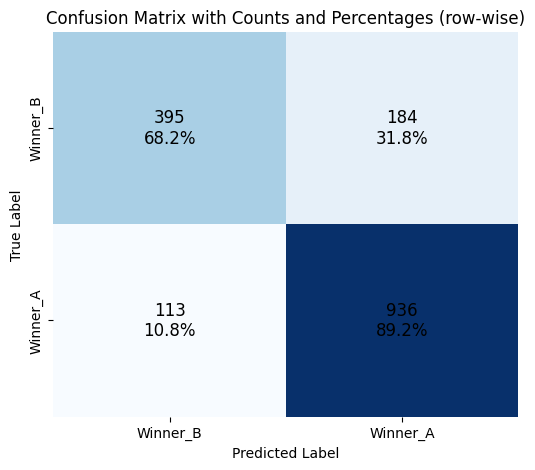

In [38]:
cm = confusion_matrix(y_test, y_pred)

labels = ['Winner_B', 'Winner_A']

# Calculate row-wise percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

# Add counts and percentages as annotation
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.5, f"{cm[i, j]}\n{cm_percent[i, j]:.1f}%", 
                 ha='center', va='center', color='black', fontsize=12)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Counts and Percentages (row-wise)')
plt.show()

In [39]:
import statsmodels.api as sm
import pandas as pd

# Add intercept (constant) to features
X_const = sm.add_constant(X)

# Fit logistic regression model with statsmodels
logit_model = sm.Logit(y, X_const)
result = logit_model.fit()

# Get the summary table as a DataFrame
summary_df = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

print(summary_df)


         Current function value: 0.393454
         Iterations: 35
                           coef  std err      z  P>|z|  [0.025  0.975]
const                   -1.6584    6.666 -0.249  0.804 -14.723  11.406
method_multiplier        1.2941    0.534  2.423  0.015   0.248   2.341
ROUND                    0.1329    0.044  3.017  0.003   0.047   0.219
rounds_scheduled        -0.2050    0.060 -3.414  0.001  -0.323  -0.087
current_elo_rating_A     0.0532    0.035  1.522  0.128  -0.015   0.122
total_fights_A           0.2164      NaN    NaN    NaN     NaN     NaN
total_wins_A            -0.6411      NaN    NaN    NaN     NaN     NaN
total_losses_A           0.2191      NaN    NaN    NaN     NaN     NaN
total_draws_A            0.6382      NaN    NaN    NaN     NaN     NaN
win_rate_A               6.4454    2.289  2.816  0.005   1.960  10.931
age_A                    0.0780    0.029  2.646  0.008   0.020   0.136
reach_inches_A          -0.0333    0.033 -0.995  0.320  -0.099   0.032
height_inch

/Users/niko/Desktop/UFC-elo-ranking/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/t0/ksd3n8r93m173jn2fpp4z7x00000gn/T/ipykernel_58894/3809724862.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  summary_df = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]


In [ ]:
# Save the Logistic Regression model
import pickle
import os

os.makedirs("../models", exist_ok=True)

model_data = {
    'model': model,
    'scaler': scaler,
    'features': list(X.columns),
    'model_type': 'LogisticRegression'
}

with open("../models/logistic_regression_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("✓ Logistic Regression model saved!")

✓ Logistic Regression model saved!
